Using the most recent _log.json by default, since no specification is given. 
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from PreCar/2022-04-25_01-23-17-994216_my_aMAP_model_with_CNVs_FS_aMAP/model
Plotting Landmark_15.0_Horizon_7.0_KMP.png


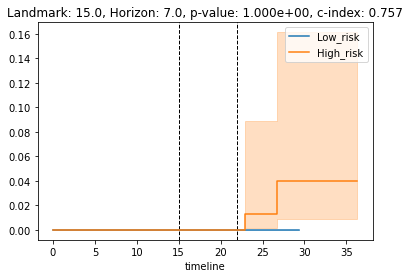

In [26]:
_EPSILON = 1e-08

#### <<< Warning suppression>>> ###
# import warnings
# warnings.filterwarnings('deprecated')
#### This makes the resulting log a lot nicer BUT could produce errors in very, very rare and unexpected circumstances. 

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
import sys
import json
import time as timepackage

from numpy import newaxis

from sklearn.model_selection import train_test_split

import import_data as impt

from class_DeepLongitudinal import Model_Longitudinal_Attention

from utils_eval             import c_index, brier_score
from utils_log              import save_logging, load_logging
from utils_helper           import f_get_minibatch, f_get_boosted_trainset



def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    """
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    """
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

## cmd args: 
# now only one argument is needed
# this will be something like "PreCar"
# and the machine will know to find all relevant materials from the "PreCar" directory





### the following codes read model training results plus needed data from Model_Training.py
# and theoretically can be used to re-construct everything needed? 

'''
saver.restore(sess, sys.argv[1])
with open(sys.argv[2]) as p: 
    params = json.load(p)
'''
sys.argv = ['xx', 'PreCar', '15', '7']
# argv[1] is the data_mode: eg if PreCar, the program will read it from the PreCar file
# argv[2], if left empty, will choose the most recent log
# if argv[2] is specified, will use the string to find relevant log
# similarly, introduce extra arguments argv[3] and argv[4] which specify evaluation landmark and horizon

# below, an example of input args
# sys.argv = ['mod', 'PreCar', '807445_my_aMAP_model_with_CNVs','1', '6', '0.01', '1']
data_mode_name = sys.argv[1]

if len(sys.argv) < 5: 
    # this means no argv[2] is given; we use the most recent log
    # to do so, for now lets just use max argument
    # firstly, take out all log.json documents
    logs = os.listdir(data_mode_name)
    # logs is a list of all available logs; find the most recent one...
    target_dir = data_mode_name + '/' + max(logs)
    print('Using the most recent _log.json by default, since no specification is given. ')
else: 
    # assume that argv[2] has specified a keyword, use the keyword to identify logs
    logs = os.listdir(data_mode_name)
    matched = [i for i in logs if sys.argv[2] in i]
    if len(matched) >= 2: 
        print('Warning: more than one log is matched with the keyword and the most recent one will be used. ')
        matched = max(matched)
    target_dir = data_mode_name + '/' + matched[0]



# read log
with open(target_dir + '/' + '_log.json') as p: 
    params = json.load(p)
mod_dir = target_dir + '/' + 'model'

# print(type(params))
new_parser = params['new_parser']
dataset_info = params['dataset_info']
evaluation_info = params['evaluation_info']
model_configs = params['model_configs']
eval_configs = params['eval_configs']
time_tag = params['new_parser']['time_tag']

dirs = dataset_info
test_dir = []
data_mode = data_mode_name
for key in list(dirs.keys()): 
    if key == data_mode: 
        train_dir = dirs[key]
    else: 
        test_dir.append(dirs[key])

(tr_x_dim, tr_x_dim_cont, tr_x_dim_bin), (tr_data, tr_time, tr_label), (tr_mask1, tr_mask2, tr_mask3), (tr_data_mi), (tr_id), tr_feat_list = impt.import_dataset(path = train_dir, bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

(te_x_dim, te_x_dim_cont, te_x_dim_bin), (te_data, te_time, te_label), (te_mask1, te_mask2, te_mask3), (te_data_mi), (te_id), te_feat_list = impt.import_dataset(path = test_dir[0], bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

(tea_x_dim, tea_x_dim_cont, tea_x_dim_bin), (tea_data, tea_time, tea_label), (tea_mask1, tea_mask2, tea_mask3), (tea_data_mi), (tea_id), tea_feat_list = impt.import_dataset(path = test_dir[1], bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

if tr_data.shape[1] > te_data.shape[1] : 
    # this means te_data have fewer follow-ups than tr_data. For this, patch it up with vectors of zero. 
    print('Test set [1] has fewer follow-ups than train set. Artificially generated follow-ups have been attached. ')
    k = tr_data.shape[1] - te_data.shape[1]
    for i in range(k): 
        te_data = np.append(te_data, np.zeros(shape = (te_data.shape[0], 1, te_data.shape[2]), dtype = float), axis = 1) 
        te_data_mi = np.append(te_data_mi, np.zeros(shape = (te_data_mi.shape[0], 1, te_data_mi.shape[2]), dtype = float), axis = 1) 

if tr_data.shape[1] > tea_data.shape[1] : 
    
    print('Test set [2] has fewer follow-ups than train set. Artificially generated follow-ups have been attached. ')
    k = tr_data.shape[1] - tea_data.shape[1]
    for i in range(k): 
        tea_data = np.append(tea_data, np.zeros(shape = (tea_data.shape[0], 1, tea_data.shape[2]), dtype = float), axis = 1) 
        tea_data_mi = np.append(tea_data_mi, np.zeros(shape = (tea_data_mi.shape[0], 1, tea_data_mi.shape[2]), dtype = float), axis = 1) 

# on the other hand what may happen if... 
if tr_data.shape[1] < te_data.shape[1] : 
    # this means te_data have fewer follow-ups than tr_data. For this, patch it up with vectors of zero. 
    print('Test set [1] has fewer follow-ups than train set. Artificially curtailed excessive follow-ups to avoid critical failures. ')
    te_data = te_data[:, range(tr_data.shape[1]), :]
    te_data_mi = te_data_mi[:, range(tr_data_mi.shape[1]), :]

if tr_data.shape[1] < tea_data.shape[1] : 
    
    print('Test set [2] has fewer follow-ups than train set. Artificially curtailed excessive follow-ups to avoid critical failures. ')
    tea_data = tea_data[:, range(tr_data.shape[1]), :]
    tea_data_mi = tea_data_mi[:, range(tr_data_mi.shape[1]), :]

if len(sys.argv) < 5: 
    eval_time = float(sys.argv[2])
    pred_time = float(sys.argv[3])
else: 
    eval_time = float(sys.argv[3])
    pred_time = float(sys.argv[4])

eval_time = [eval_time]
pred_time = [pred_time]

_, num_Event, num_Category  = np.shape(tr_mask1)  # dim of mask3: [subj, Num_Event, Num_Category]

max_length                  = np.shape(tr_data)[1]

#####


# A little treat: print name (in dict) of dataset
def get_key(val):
    for key, value in dataset_info.items():
         if val == value:
             return key
 
    return "There is no such Key"

train_name = get_key(train_dir)
test1_name = get_key(test_dir[0])
test2_name = get_key(test_dir[1])


#####

input_dims                  = { 'x_dim'         : tr_x_dim,
                                'x_dim_cont'    : tr_x_dim_cont,
                                'x_dim_bin'     : tr_x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : tf.nn.relu,
                                'RNN_active_fn'     : tf.nn.tanh,
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : float(new_parser['reg_W_out'])
                                 }

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dynamic-DeepHit", input_dims, network_settings)

saver = tf.train.Saver()
saver.restore(sess, mod_dir)

# By default, at each landmark time and horizon, both c-index and Brier score will be computed
# Results will be printed, and saved in a _log.txt document

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)



from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

prange = list(range(len(pred_time)))
erange = list(range(len(eval_time)))

# create figures directory
fig_dir = target_dir + '/eval/figures/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

for pidx in prange: 
    for eidx in erange: 
        
        # firstly, if there is no event in this range, the programme will return with error
        # check with df1
        if df1.iloc[pidx, eidx] == 0: 
            this_pred_time = pred_time[pidx]
            this_eval_time = eval_time[eidx]
            print('There is no event during the following timeframe: [' + str(this_eval_time) + ", " + str(this_eval_time + this_pred_time) + "], therefore no discrimination could be made and no KM plot could be produced in this way. ")
        else: 
            
            risk = risk_all[0]

            risk = risk[:, pidx, eidx]
            this_pred_time = pred_time[pidx]
            this_eval_time = eval_time[eidx]

            fig_name = 'Landmark_' + str(this_eval_time) + '_Horizon_' + str(this_pred_time) + '_KMP.png'
            print('Plotting ' + fig_name)

            # identify pops who are still susceptible
            eval_horizon = this_eval_time
            idx = [i > eval_horizon for i in list(te_time[:, 0])]
            te_data_sub = te_data[idx, :, :]

            # for these patients, their risks
            risk_sub = risk[idx]

            # patient id and time
            te_time_sub = te_time[idx, 0]
            te_label_sub = te_label[idx, 0]

            # check how many patients left
            # print('Time-varying sample size: ' + str(risk_sub.shape[0]))

            risk_max = max(risk_sub)
            risk_min = min(risk_sub)

            # construct a range of risks
            step_size = (risk_max - risk_min)/100
            steps = [risk_min + (i + 1) * step_size for i in range(100-1)]

            # this is a good 100-sized step, checked

            # now develop that into a for loop...
            pvalL = []

            for step in steps: 



                # divide pops based on the step
                grp1_idx = [i > step for i in risk_sub]
                grp0_idx = [i <= step for i in risk_sub]

                grp1_data = te_data_sub[grp1_idx, :, :]
                grp1_time = te_time_sub[grp1_idx]
                grp1_label = te_label_sub[grp1_idx]

                # new label that is time-dynamic
                grp1_label_idx = [i for i in range(len(grp1_label)) if grp1_label[i] == 1 and grp1_time[i] < this_eval_time + this_pred_time]
                grp1_label_new = np.zeros(len(grp1_label))
                grp1_label_new[grp1_label_idx] = 1

                grp0_data = te_data_sub[grp0_idx, :, :]
                grp0_time = te_time_sub[grp0_idx]
                grp0_label = te_label_sub[grp0_idx]

                grp0_label_idx = [i for i in range(len(grp0_label)) if grp0_label[i] == 1 and grp0_time[i] < this_eval_time + this_pred_time]
                grp0_label_new = np.zeros(len(grp0_label))
                grp0_label_new[grp0_label_idx] = 1


                # now KM
                lrt = logrank_test(grp0_time, grp1_time, grp0_label_new, grp1_label_new)
                # print p value, just to check
                # print('p value: ' + str(lrt.p_value))
                # log p value
                pvalL.append(lrt.p_value)

            min_p = min(pvalL)
            min_p_idx = [i for i in range(len(steps)) if pvalL[i] == min_p][0]
            min_p_steps = steps[min_p_idx]

            # let us use steps[50]
            step = steps[min_p_idx]

            # divide pop into two risk 
            # identify pops who are still susceptible
            eval_horizon = this_eval_time
            idx = [i > eval_horizon for i in list(te_time[:, 0])]
            te_data_sub = te_data[idx, :, :]

            # for these patients, their risks
            risk_sub = risk[idx]

            # patient id and time
            te_time_sub = te_time[idx, 0]
            te_label_sub = te_label[idx, 0]

            # divide pops based on the step
            grp1_idx = [i > step for i in risk_sub]
            grp0_idx = [i <= step for i in risk_sub]

            grp1_data = te_data_sub[grp1_idx, :, :]
            grp1_time = te_time_sub[grp1_idx]
            grp1_label = te_label_sub[grp1_idx]
            # apply a mask
            # for i in range(len(grp1_label)): 
                # grp1_label[i] = 

            grp0_data = te_data_sub[grp0_idx, :, :]
            grp0_time = te_time_sub[grp0_idx]
            grp0_label = te_label_sub[grp0_idx]


            # now KM
            # lrt = logrank_test(grp0_time, grp1_time, grp0_label, grp1_label)
            # here, K-M curve fitting

            # first param is grpx_time, second param is grpx_label

            # reset the plotting canvas
            plt.figure()
            

            window_lb = this_eval_time
            if window_lb == 1: 
                window_lb = 0
            # print(window_lb)
            window_up = this_eval_time + this_pred_time
            plt.axvline(x = window_lb, linestyle ="--", color = 'black', linewidth = 1)
            plt.axvline(x = window_up, linestyle ="--", color = 'black', linewidth = 1)
            
            
            max_time = max([max(grp0_time), max(grp1_time)])
            # print(window_up)
            kmf1 = KaplanMeierFitter()
            kmf1.fit(grp0_time, grp0_label, label = "Low_risk")
            p0 = kmf1.plot_cumulative_density(loc = slice(0, max_time))

            kmf1.fit(grp1_time, grp1_label, label = "High_risk")
            p1 = kmf1.plot_cumulative_density(ax = p0, loc = slice(0, max_time))
            
            pfin = p1.get_figure()
            
            plt.title('Landmark: ' + str(this_eval_time) + ', Horizon: ' + str(this_pred_time) + ', p-value: ' + str('%.3e'%min_p) + ', c-index: ' + str('%.3f'%df1.iloc[pidx, eidx]))
            # plt.xticks(x = range(0, 36, 6))
            fig_name = 'Landmark_' + str(this_eval_time) + '_Horizon_' + str(this_pred_time) + '_KMP.png'
            # pfin.savefig(target_dir + '/eval/figures/' + fig_name)
            plt.show()
            
            # add the small table
            
            del p0
            del p1 
            del pfin
            del kmf1

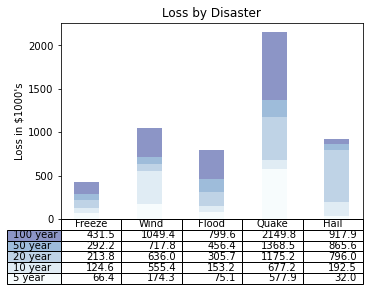

In [15]:
import numpy as np
import matplotlib.pyplot as plt


data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]

values = np.arange(0, 2500, 500)
value_increment = 1000

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.1f' % (x / 1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Loss by Disaster')

plt.show()

In [31]:
eval_tab = list(range(1, 25, 6))
KM_table = []
for eval in eval_tab: 
    KM_table.append([, ])

[1, 7, 13, 19]

In [54]:
sum(np.array(te_time[:, 0] > 0) * np.transpose(risk > step))

1767

[array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True]

In [52]:
te_time

array([[14.93333333],
       [12.3       ],
       [13.53333333],
       ...,
       [12.06666667],
       [11.43333333],
       [11.63333333]])